In [19]:

# Importing modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [20]:
# Reading in the data
tesla = pd.read_csv(r'C:\Users\Daniel\Documents\VSCode\_MyProjects\Predict Stock - TESLA\data\TSLA.csv')
tesla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [21]:
#Isolate date and closing price
tesla = tesla[['Date', 'Close']]

In [22]:
tesla.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [23]:
#Covert date to datetime object
tesla.Date = pd.to_datetime(tesla.Date, format = '%Y/%m/%d')

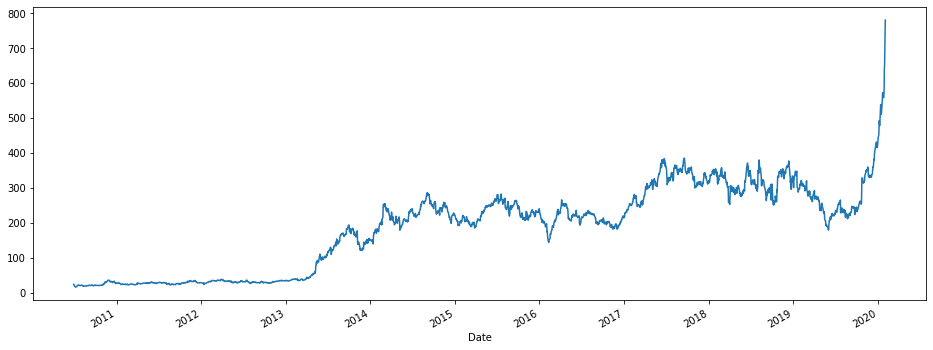

In [24]:
#Plot the data
plot_tesla = tesla.set_index('Date')
plot_tesla['Close'].plot(figsize = (16,6));

In [25]:
#Select data to predict

#Start = 1/1/14 - index = 884
#End = 31/12/16 - index = 1639

new_tesla = tesla.loc[884:1639]
new_tesla.head()

,Date,Close
884,2014-01-02,150.100006
885,2014-01-03,149.559998
886,2014-01-06,147.000000
887,2014-01-07,149.360001
888,2014-01-08,151.279999


In [26]:
new_tesla.tail()

,Date,Close
1635,2016-12-23,213.339996
1636,2016-12-27,219.529999
1637,2016-12-28,219.740005
1638,2016-12-29,214.679993
1639,2016-12-30,213.690002


In [27]:
#Feature Pre-processing

#min / max scaling & train, test, split
new_tesla = new_tesla.drop('Date', axis = 1)
new_tesla = new_tesla.reset_index(drop = True)
new_tesla.head()
T = new_tesla.values
T = T.astype('float32')
T = np.reshape(T, (-1, 1))


In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
T = scaler.fit_transform(T)

# 80-20 split
train_size = int(len(T) * 0.80)
test_size = int(len(T) - train_size)
train, test = T[0:train_size,:], T[train_size:len(T),:]

In [29]:
# Method for create features from the time series data
def create_features(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

# Roughly one month of trading assuming 5 trading days per week
window_size = 20
X_train, Y_train = create_features(train, window_size)

X_test, Y_test = create_features(test, window_size)

# Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [30]:
# Checking to make sure that none of our training set is leaking into the testing set
T_shape = T.shape
train_shape = train.shape
test_shape = test.shape

# Make sure that the number of rows in the dataset = train rows + test rows
def isLeak(T_shape, train_shape, test_shape):
    return not(T_shape[0] == (train_shape[0] + test_shape[0]))

print(isLeak(T_shape, train_shape, test_shape))

False


In [31]:
#Recurrent Neural Network - Long Short Term Memory
#One layer / 50 Neurons

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint

# Setting seed for reproducibility 
tf.random.set_seed(11)
np.random.seed(11)

In [32]:
#Model Build
model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', #return_sequences = True, 
                input_shape = (X_train.shape[1], window_size)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')


In [35]:
filepath = 'model/model_epoch_{epoch:02d}.hdf5'

checkpoint = ModelCheckpoint(filepath= filepath, monitor = 'val_loss', 
                                verbose = 1, save_best_only = False, mode = 'min')
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 20, 
                    validation_data = (X_test, Y_test), callbacks = [checkpoint], 
                    verbose = 1, shuffle = False)
model.summary()


ving model to model\model_epoch_14.hdf5
30/30 [==============================] - 0s 7ms/step - loss: 0.0044 - val_loss: 8.9067e-04
Epoch 15/100
30/30 [==============================] - ETA: 0s - loss: 0.0046
Epoch 00015: saving model to model\model_epoch_15.hdf5
30/30 [==============================] - 0s 7ms/step - loss: 0.0046 - val_loss: 8.9672e-04
Epoch 16/100
27/30 [==========================>...] - ETA: 0s - loss: 0.0049
Epoch 00016: saving model to model\model_epoch_16.hdf5
30/30 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 8.6560e-04
Epoch 17/100
20/30 [===================>..........] - ETA: 0s - loss: 0.0048
Epoch 00017: saving model to model\model_epoch_17.hdf5
30/30 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 9.2823e-04
Epoch 18/100
24/30 [=======================>......] - ETA: 0s - loss: 0.0044
Epoch 00018: saving model to model\model_epoch_18.hdf5
30/30 [==============================] - 0s 9ms/step - loss: 0.0044 

In [36]:
#Model 89 has lowest loss'

#Predicting and inverse transforming the preds
from keras.models import load_model
best_model = load_model('model\model_epoch_89.hdf5')

train_predict = best_model.predict(X_train)
Y_hat_train = scaler.inverse_transform(train_predict)
test_predict = best_model.predict(X_test)
Y_hat_test = scaler.inverse_transform(test_predict)

#inverse transforming the actual vals to return to originals
Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])


In [37]:
Y_hat_train = np.reshape(Y_hat_train, newshape = 583)
Y_hat_test = np.reshape(Y_hat_test, newshape = 131)
Y_train = np.reshape(Y_train, newshape = 583)
Y_test = np.reshape(Y_test, newshape = 131)

In [41]:
#Evaluating model performance

#Root Mean Square Error
from sklearn.metrics import mean_squared_error

train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_hat_train))
test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_hat_test))
print('Train RMSE is:', round(train_RMSE,2),'\n')
print('Test RMSE is:', round(test_RMSE,2), '\n')


Train RMSE is: 6.39 

Test RMSE is: 4.47 



In [42]:
#Visualising the predicted stocks
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_hat_train, Y_hat_test)

result_df = pd.DataFrame()
result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat
result_df.head()

,Actual_Y,Predicted_Y
0,181.410008,183.910187
1,177.110005,184.190582
2,178.729989,182.711960
3,174.420000,183.123291
4,178.380001,182.074219


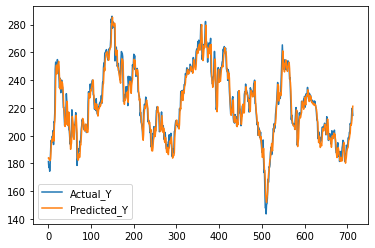

In [43]:
result_df.plot();